In [1]:
from math import pi
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

print(matplotlib.__version__)

3.3.4


# Dummy data
Example data from Simple Maze experiment

In [2]:
data = {
    'knowledge': {
        'acs': 0.965583791151306,
        'acs2': 1.0,
        'acs2_oiq': 1.0,
        'acs2_ga': 1.0,
        'acs2_ga_oiq': 1.0,
        'yacs': 0.9996568244234288,
        'dynaq': 1.0
    },
    'generalization': {
        'acs': 0.5100775438173071,
        'acs2': 0.32915741200500215,
        'acs2_oiq': 0.32718385603111283,
        'acs2_ga': 0.4497699933116077,
        'acs2_ga_oiq': 0.4633747816070859,
        'yacs': 0.2648783105127738,
        'dynaq': 0.0
    },
    'population': {
        'acs': 21.308725023654706,
        'acs2': 30.87262528169257,
        'acs2_oiq': 31.408566677954582,
        'acs2_ga': 53.36912639210381,
        'acs2_ga_oiq': 51.731551874298056,
        'yacs': 26.475892899332568,
        'dynaq': 32.0
    },
    'time': {
        'acs': 0.004793949073293424,
        'acs2': 0.0037916348348480356,
        'acs2_oiq': 0.004074112409821036,
        'acs2_ga': 0.0085332134951495,
        'acs2_ga_oiq': 0.01218595293419769,
        'yacs': 0.03866807075752569,
        'dynaq': 0.0017192906935970917
    }
}

df = pd.DataFrame(data)
df

,knowledge,generalization,population,time
acs,0.965584,0.510078,21.308725,0.004794
acs2,1.000000,0.329157,30.872625,0.003792
acs2_oiq,1.000000,0.327184,31.408567,0.004074
acs2_ga,1.000000,0.449770,53.369126,0.008533
acs2_ga_oiq,1.000000,0.463375,51.731552,0.012186
yacs,0.999657,0.264878,26.475893,0.038668
dynaq,1.000000,0.000000,32.000000,0.001719


In [3]:
# df=(df-df.mean())/df.std()
df=(df-df.min())/(df.max()-df.min())
df

,knowledge,generalization,population,time
acs,0.000000,1.000000,0.000000,0.083214
acs2,1.000000,0.645309,0.298309,0.056087
acs2_oiq,1.000000,0.641439,0.315025,0.063732
acs2_ga,1.000000,0.881768,1.000000,0.184415
acs2_ga_oiq,1.000000,0.908440,0.948922,0.283275
yacs,0.990029,0.519290,0.161170,1.000000
dynaq,1.000000,0.000000,0.333473,0.000000


In [4]:
attributes = list(df)
attributes

['knowledge', 'generalization', 'population', 'time']

In [5]:
attributes_no = len(attributes)
attributes_no

4

In [6]:
# take row with index 1
values = df.iloc[1].tolist()
values += values[:1]  # copy the first value to the end
values

[1.0, 0.6453085731664664, 0.29830881242334584, 0.056086943538200304, 1.0]

In [7]:
# find angles between the points
angles = [n / float(attributes_no) * 2 * pi for n in range(attributes_no)]
angles += angles[:1]
angles

[0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]

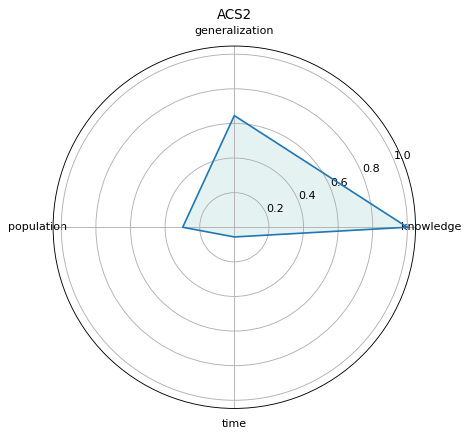

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.subplot(111, polar=True)

# add the attribute labels to our axes
plt.xticks(angles[:-1], attributes)

# plot the line around the outside of the filled area, using the angles and values calculated before
ax.plot(angles, values)

# fill in the area plotted in the last line
ax.fill(angles, values, 'teal', alpha=0.1)

# give the plot a title and show it
ax.set_title("ACS2")
plt.show()

In [9]:
# algs = ['acs', 'acs2', 'acs2_ga', 'dynaq']
algs = df.index.to_list()

algs

['acs', 'acs2', 'acs2_oiq', 'acs2_ga', 'acs2_ga_oiq', 'yacs', 'dynaq']

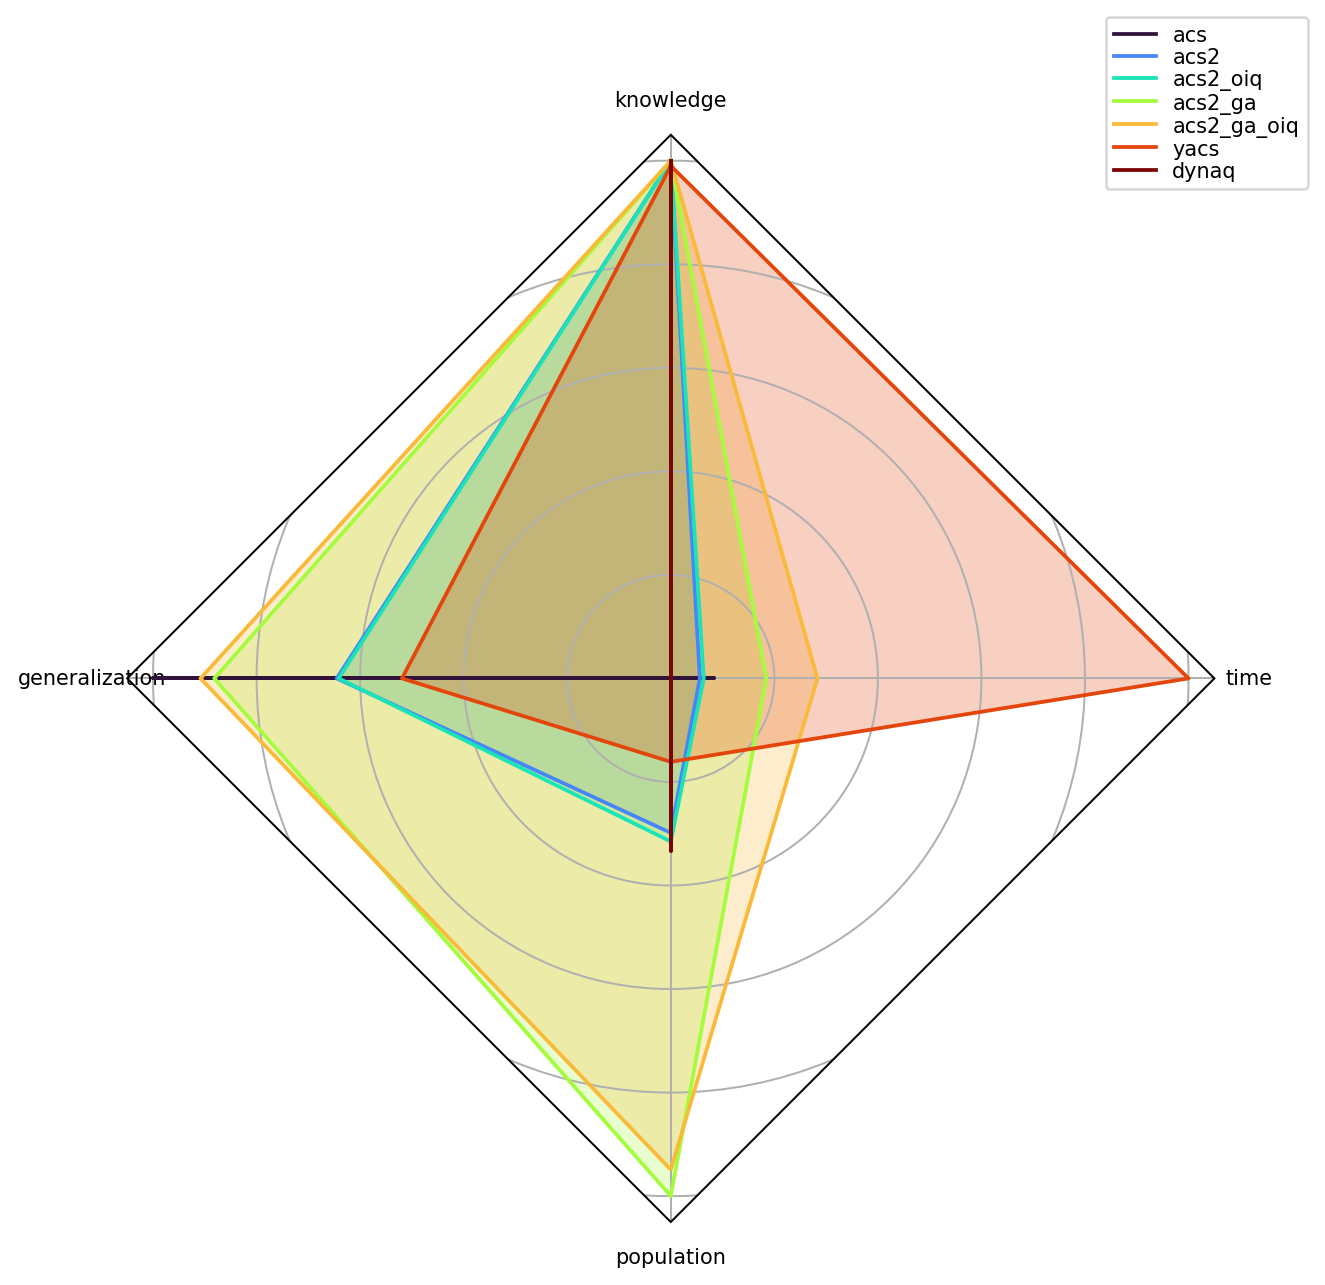

In [13]:
def radar_factory(num_vars, frame='circle'):

    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, size='small')

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


my_palette = plt.cm.get_cmap("turbo", len(df.index))

fig, axs = plt.subplots(ncols=1, nrows=1, subplot_kw=dict(projection='radar'), figsize=(8, 8), dpi=180)
# fig.subplots_adjust(wspace=0.5, hspace=0.20, top=0.85, bottom=0.05)

theta = radar_factory(attributes_no, frame='polygon')

# for i, (ax, alg) in enumerate(zip(axs.flat, algs)):
#     ax.get_yaxis().set_ticklabels([])
#     ax.set_title(alg, weight='bold', size='medium', position=(0.5, 1.1),
#                  horizontalalignment='center', verticalalignment='center')
#
#     v = df.loc[alg].to_list()
#
#     ax.plot(theta, v, color=my_palette(i))
#     ax.fill(theta, v, facecolor=my_palette(i), alpha=0.25)
#
#     ax.set_varlabels(attributes)


for i, alg in enumerate(algs):
    # ax = axs[0][0]
    ax = axs
    ax.get_yaxis().set_ticklabels([])
    v = df.loc[alg].to_list()
    ax.plot(theta, v, color=my_palette(i))
    ax.fill(theta, v, facecolor=my_palette(i), alpha=0.25)
    ax.set_varlabels(attributes)

    legend = ax.legend(algs, loc=(0.9, .95), labelspacing=0.1, fontsize='small')

plt.show()